In [1]:
import datetime
import utils
import pymysql
import sshtunnel
import pandas as pd 
import numpy as np 
from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.utilities import v_relative, clo_dynamic
from math import exp, sqrt
import os
from datetime import datetime
import json

# Importación de datos de mysql mediante ssh

## Inicializaciones

### Query

In [2]:
import datetime
# tabla
tabla = "data"

# Variables seleccionadas tabla
#ToDo: Revisar por qué se convierte a minusc. Tiene pinta de alguna configuración de la bbdd
variables = ["UPPER(id_sensor) AS id_sensor","variable","value","unit","timestamp"] #upper porque se cogen convierten los datos a minusc.

# Id sensores
id_sensores = ["70B3D57BA0001C2D","QUCONTFUAU1AULA1001"]
sql_filtro_sensores = " OR ".join([ f"id_sensor = '{id}'" for id in id_sensores])

# Definir la fecha de inicio a partir de la cual seleccionamos los datos
fecha_inicio = datetime.datetime(2023, 5, 5, 7, 26, 0)

# Query
query = f"""
SELECT 
    {",".join(variables)}
FROM 
    {tabla}
WHERE 
    ({sql_filtro_sensores})
    AND timestamp >= '{fecha_inicio.strftime('%Y-%m-%d %H:%M:%S')}'
ORDER BY TIMESTAMP DESC
"""

In [3]:
print(query)


SELECT 
    UPPER(id_sensor) AS id_sensor,variable,value,unit,timestamp
FROM 
    data
WHERE 
    (id_sensor = '70B3D57BA0001C2D' OR id_sensor = 'QUCONTFUAU1AULA1001')
    AND timestamp >= '2023-05-05 07:26:00'
ORDER BY TIMESTAMP DESC



### Credenciales

In [4]:
# Abro el archivo de sql.json en creds y lo cargo. Esto me devuelve un diccionario de python
with open('creds/sql.json', 'r') as json_file:
    creds_sql = json.load(json_file)

## Importación

In [5]:
# get_data_ssh es una función que crea directamente el DataFrame de python al poner la query 
# en sql. Es una función propio del script utils en el proyecto 
df_imported = utils.get_data_ssh(query, database="smartcampus_demo", **creds_sql)
df_imported

,id_sensor,variable,value,unit,timestamp
0,70B3D57BA0001C2D,Battery voltage,2.7330,V,2023-07-11 14:08:19
1,70B3D57BA0001C2D,Air temperature,27.4807,°C,2023-07-11 14:08:19
2,70B3D57BA0001C2D,Air humidity,35.7275,%,2023-07-11 14:08:19
3,70B3D57BA0001C2D,Barometric pressure,93834.0000,Pa,2023-07-11 14:08:19
4,70B3D57BA0001C2D,Ambient light (visible + infrared),0.0000,None,2023-07-11 14:08:19
...,...,...,...,...,...
157895,70B3D57BA0001C2D,CO2 concentration,426.0000,ppm,2023-05-05 07:29:44
157896,70B3D57BA0001C2D,CO2 sensor status,0.0000,None,2023-05-05 07:29:44
157897,70B3D57BA0001C2D,Raw IR reading,38183.0000,None,2023-05-05 07:29:44
157898,70B3D57BA0001C2D,Activity counter,0.0000,None,2023-05-05 07:29:44


In [6]:
df = df_imported.copy()
df

,id_sensor,variable,value,unit,timestamp
0,70B3D57BA0001C2D,Battery voltage,2.7330,V,2023-07-11 14:08:19
1,70B3D57BA0001C2D,Air temperature,27.4807,°C,2023-07-11 14:08:19
2,70B3D57BA0001C2D,Air humidity,35.7275,%,2023-07-11 14:08:19
3,70B3D57BA0001C2D,Barometric pressure,93834.0000,Pa,2023-07-11 14:08:19
4,70B3D57BA0001C2D,Ambient light (visible + infrared),0.0000,None,2023-07-11 14:08:19
...,...,...,...,...,...
157895,70B3D57BA0001C2D,CO2 concentration,426.0000,ppm,2023-05-05 07:29:44
157896,70B3D57BA0001C2D,CO2 sensor status,0.0000,None,2023-05-05 07:29:44
157897,70B3D57BA0001C2D,Raw IR reading,38183.0000,None,2023-05-05 07:29:44
157898,70B3D57BA0001C2D,Activity counter,0.0000,None,2023-05-05 07:29:44


# Limpieza de datos

## Duplicados

In [7]:
# ¡OJO! hay observaciones duplicadas. Esto es, hay observaciones tales que los sensores,
# para ciertos instantes de tiempo, han envíado la información muchas veces en la bbdd.
# ToDo: Investigar por qué ha ocurrido esto y tenerlo trackeado por si acaso
df[df.duplicated()]

,id_sensor,variable,value,unit,timestamp
152,QUCONTFUAU1AULA1001,Occupancy,0.0,people,2023-07-11 12:20:01
153,QUCONTFUAU1AULA1001,Occupancy,0.0,people,2023-07-11 12:20:01
292,QUCONTFUAU1AULA1001,Occupancy,0.0,people,2023-07-11 10:45:01
1322,QUCONTFUAU1AULA1001,Occupancy,0.0,people,2023-07-10 22:00:01
2864,QUCONTFUAU1AULA1001,Occupancy,0.0,people,2023-07-10 03:30:01
...,...,...,...,...,...
157611,70B3D57BA0001C2D,CO2 concentration,704.0,ppm,2023-05-05 11:09:35
157612,70B3D57BA0001C2D,CO2 sensor status,0.0,None,2023-05-05 11:09:35
157613,70B3D57BA0001C2D,Raw IR reading,37027.0,None,2023-05-05 11:09:35
157614,70B3D57BA0001C2D,Activity counter,0.0,None,2023-05-05 11:09:35


In [8]:
# Quitamos esos duplicados 
df = df.drop_duplicates()
df

,id_sensor,variable,value,unit,timestamp
0,70B3D57BA0001C2D,Battery voltage,2.7330,V,2023-07-11 14:08:19
1,70B3D57BA0001C2D,Air temperature,27.4807,°C,2023-07-11 14:08:19
2,70B3D57BA0001C2D,Air humidity,35.7275,%,2023-07-11 14:08:19
3,70B3D57BA0001C2D,Barometric pressure,93834.0000,Pa,2023-07-11 14:08:19
4,70B3D57BA0001C2D,Ambient light (visible + infrared),0.0000,None,2023-07-11 14:08:19
...,...,...,...,...,...
157895,70B3D57BA0001C2D,CO2 concentration,426.0000,ppm,2023-05-05 07:29:44
157896,70B3D57BA0001C2D,CO2 sensor status,0.0000,None,2023-05-05 07:29:44
157897,70B3D57BA0001C2D,Raw IR reading,38183.0000,None,2023-05-05 07:29:44
157898,70B3D57BA0001C2D,Activity counter,0.0000,None,2023-05-05 07:29:44


## Checkeo valores nulos

In [9]:
df.isna().sum()

id_sensor    0
variable     0
value        0
unit         0
timestamp    0
dtype: int64

## Checkeo de las unidades de de medición y normalización

In [10]:
# Lo primero de todo me aseguro que solo hay una unidad por variable. En caso de que no habría que hacer las transformaciones
# entre unidades equivalentes para normalizarlo, por ejemplo, kelvin a ºC:
# Para ello, hago un groupby a nivel id_sensor, variable y cuento el número de unidades distintas que hay para cada grupo
df_check_unit = df.groupby(["id_sensor","variable"])["unit"]\
.apply(lambda x: len(set(x)))\
.reset_index()\
.rename(columns={"unit":"number_different_units"})
df_check_unit

,id_sensor,variable,number_different_units
0,70B3D57BA0001C2D,Activity counter,1
1,70B3D57BA0001C2D,Air humidity,1
2,70B3D57BA0001C2D,Air temperature,1
3,70B3D57BA0001C2D,Ambient light (infrared),1
4,70B3D57BA0001C2D,Ambient light (visible + infrared),1
5,70B3D57BA0001C2D,Barometric pressure,1
6,70B3D57BA0001C2D,Battery voltage,1
7,70B3D57BA0001C2D,CO2 concentration,1
8,70B3D57BA0001C2D,CO2 sensor status,1
9,70B3D57BA0001C2D,Illuminance,1


In [11]:
if sum(df_check_unit["number_different_units"] > 1) == 0:
    print("Para todo sensor y para toda variable solo se una unidad, no hay que normalizar nada")
else: 
    print("¡Cuidado! hay sensores que para alguna variable se miden en diferentes unidades")

Para todo sensor y para toda variable solo se una unidad, no hay que normalizar nada


In [12]:
#Una vez esté todo normalizado a la misma unidad, nos podemos cargar la columna, pues es innecesaria:
df.drop(columns="unit",inplace=True)
df

,id_sensor,variable,value,timestamp
0,70B3D57BA0001C2D,Battery voltage,2.7330,2023-07-11 14:08:19
1,70B3D57BA0001C2D,Air temperature,27.4807,2023-07-11 14:08:19
2,70B3D57BA0001C2D,Air humidity,35.7275,2023-07-11 14:08:19
3,70B3D57BA0001C2D,Barometric pressure,93834.0000,2023-07-11 14:08:19
4,70B3D57BA0001C2D,Ambient light (visible + infrared),0.0000,2023-07-11 14:08:19
...,...,...,...,...
157895,70B3D57BA0001C2D,CO2 concentration,426.0000,2023-05-05 07:29:44
157896,70B3D57BA0001C2D,CO2 sensor status,0.0000,2023-05-05 07:29:44
157897,70B3D57BA0001C2D,Raw IR reading,38183.0000,2023-05-05 07:29:44
157898,70B3D57BA0001C2D,Activity counter,0.0000,2023-05-05 07:29:44


## Conversión de la fecha a timestamp

In [13]:
df.dtypes

id_sensor            object
variable             object
value               float64
timestamp    datetime64[ns]
dtype: object

In [14]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [15]:
df.dtypes

id_sensor            object
variable             object
value               float64
timestamp    datetime64[ns]
dtype: object

## Normalización y redondeo del tiempo

In [16]:
# # Los sensores toman valores en intervalos irregulares. Los normalizamos de modo que si, por ejemplo, 
# # se toma el valor a las 13:42 se aproxime a las 13:40. Esto servirá además por si dos sensores que 
# # toman variables distintas, por ejemplo occupancy a las 13:41 y temperatura a las 13:42,
# # se normalicen ambos datos a 13:40

from datetime import datetime, timedelta

def round_minutes(date, interval=5):
    # date: se espera que tenga la forma '%Y-%m-%d %H:%M'
    dt = datetime.strptime(date, '%Y-%m-%d %H:%M')
    
    rounded_minute = (dt.minute // interval) * interval
    if dt.minute % interval >= interval / 2:
        rounded_minute += interval
        
    if rounded_minute == 60:
        rounded_dt = dt.replace(minute=0) + timedelta(hours=1)
    else:
        rounded_dt = dt.replace(minute=rounded_minute)
        
    rounded_dt = rounded_dt.replace(second=0, microsecond=0)
    
    return rounded_dt.strftime('%Y-%m-%d %H:%M')

In [17]:
# Aplicamos la función anterior y guardamos la columna anterior para hacer checkeos si fuera 
# necesario en algún momento 
df["timestamp_original"] = df["timestamp"] 
# df["timestamp"] = pd.to_datetime(df["timestamp"])
df["timestamp"] = [round_minutes(date) for date in df["timestamp"].dt.strftime('%Y-%m-%d %H:%M')]
df["timestamp"] = pd.to_datetime(df["timestamp"])
df

,id_sensor,variable,value,timestamp,timestamp_original
0,70B3D57BA0001C2D,Battery voltage,2.7330,2023-07-11 14:10:00,2023-07-11 14:08:19
1,70B3D57BA0001C2D,Air temperature,27.4807,2023-07-11 14:10:00,2023-07-11 14:08:19
2,70B3D57BA0001C2D,Air humidity,35.7275,2023-07-11 14:10:00,2023-07-11 14:08:19
3,70B3D57BA0001C2D,Barometric pressure,93834.0000,2023-07-11 14:10:00,2023-07-11 14:08:19
4,70B3D57BA0001C2D,Ambient light (visible + infrared),0.0000,2023-07-11 14:10:00,2023-07-11 14:08:19
...,...,...,...,...,...
157895,70B3D57BA0001C2D,CO2 concentration,426.0000,2023-05-05 07:30:00,2023-05-05 07:29:44
157896,70B3D57BA0001C2D,CO2 sensor status,0.0000,2023-05-05 07:30:00,2023-05-05 07:29:44
157897,70B3D57BA0001C2D,Raw IR reading,38183.0000,2023-05-05 07:30:00,2023-05-05 07:29:44
157898,70B3D57BA0001C2D,Activity counter,0.0000,2023-05-05 07:30:00,2023-05-05 07:29:44


In [18]:
# Podría pasar que para un mismo sensor se agrupen varias observaciones con un mismo timestamp 
# aproximado
df.query("variable=='CO2 concentration'")\
.groupby(["id_sensor","timestamp","variable"])["timestamp_original"].size().reset_index()\
.query("timestamp_original>1 & variable=='CO2 concentration'")\
.rename(columns={"timestamp_original":"n_timestamps"})\
.sort_values(by="n_timestamps", ascending=False)

,id_sensor,timestamp,variable,n_timestamps
8086,70B3D57BA0001C2D,2023-07-01 13:40:00,CO2 concentration,2
8241,70B3D57BA0001C2D,2023-07-02 18:30:00,CO2 concentration,2
8300,70B3D57BA0001C2D,2023-07-03 06:00:00,CO2 concentration,2
8299,70B3D57BA0001C2D,2023-07-03 05:50:00,CO2 concentration,2
8287,70B3D57BA0001C2D,2023-07-03 03:50:00,CO2 concentration,2
...,...,...,...,...
8162,70B3D57BA0001C2D,2023-07-02 03:50:00,CO2 concentration,2
8161,70B3D57BA0001C2D,2023-07-02 03:40:00,CO2 concentration,2
8160,70B3D57BA0001C2D,2023-07-02 03:30:00,CO2 concentration,2
8159,70B3D57BA0001C2D,2023-07-02 03:20:00,CO2 concentration,2


In [19]:
# Desglosando un ejemplo de la tabla anterior
df.query("id_sensor == '70B3D57BA0001C2D'" 
         + "& timestamp== '2020-11-26 19:15:00'"
         + "& variable == 'CO2 concentration'" )

,id_sensor,variable,value,timestamp,timestamp_original


In [20]:
# Vamos a agrupar esas observaciones por la media:
# Nota: Sería interesante trackear los timestamps originales y guardar en forma de lista después para hacer checkeos, pero 
# como tarda en hacerse y no tiene utilidad más allá que checkeo no lo voy a hacer
df= df.groupby(["id_sensor","timestamp","variable"])["value"].mean().reset_index()
df

,id_sensor,timestamp,variable,value
0,70B3D57BA0001C2D,2023-05-05 07:30:00,Activity counter,0.0000
1,70B3D57BA0001C2D,2023-05-05 07:30:00,Air humidity,33.1060
2,70B3D57BA0001C2D,2023-05-05 07:30:00,Air temperature,23.1975
3,70B3D57BA0001C2D,2023-05-05 07:30:00,Ambient light (infrared),61.0000
4,70B3D57BA0001C2D,2023-05-05 07:30:00,Ambient light (visible + infrared),255.0000
...,...,...,...,...
132388,QUCONTFUAU1AULA1001,2023-07-11 13:45:00,Occupancy,0.0000
132389,QUCONTFUAU1AULA1001,2023-07-11 13:50:00,Occupancy,0.0000
132390,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,Occupancy,0.0000
132391,QUCONTFUAU1AULA1001,2023-07-11 14:00:00,Occupancy,0.0000


In [21]:
# Compruebo si sigue habiendo observaciones duplicadas:
sum(df.groupby(["id_sensor","timestamp","variable"]).size()>1)

0

In [22]:
# Guardo el dataframe en este estado para hacer checkeos en las transformaciones siguientes 
df_level_id_sensor_timestamp_variable = df.copy()
df_level_id_sensor_timestamp_variable

,id_sensor,timestamp,variable,value
0,70B3D57BA0001C2D,2023-05-05 07:30:00,Activity counter,0.0000
1,70B3D57BA0001C2D,2023-05-05 07:30:00,Air humidity,33.1060
2,70B3D57BA0001C2D,2023-05-05 07:30:00,Air temperature,23.1975
3,70B3D57BA0001C2D,2023-05-05 07:30:00,Ambient light (infrared),61.0000
4,70B3D57BA0001C2D,2023-05-05 07:30:00,Ambient light (visible + infrared),255.0000
...,...,...,...,...
132388,QUCONTFUAU1AULA1001,2023-07-11 13:45:00,Occupancy,0.0000
132389,QUCONTFUAU1AULA1001,2023-07-11 13:50:00,Occupancy,0.0000
132390,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,Occupancy,0.0000
132391,QUCONTFUAU1AULA1001,2023-07-11 14:00:00,Occupancy,0.0000


In [23]:
#df= df_level_id_sensor_timestamp_variable.copy()

## Tranformación del DataFrame a nivel timestamp, id_sensor 

In [24]:
# El DataFrame anterior está a nivel id_sensor,variable, . Lo normalizacmos a nivel timestamp, id_sensor
df = pd.pivot_table(df,index=["timestamp","id_sensor"],columns=["variable"]).reset_index()
df

timestamp            id_sensor            value  \
variable                                          Activity counter   
0        2023-05-05 07:30:00     70B3D57BA0001C2D              0.0   
1        2023-05-05 07:30:00  QUCONTFUAU1AULA1001              NaN   
2        2023-05-05 07:35:00  QUCONTFUAU1AULA1001              NaN   
3        2023-05-05 07:40:00     70B3D57BA0001C2D              0.0   
4        2023-05-05 07:40:00  QUCONTFUAU1AULA1001              NaN   
...                      ...                  ...              ...   
28383    2023-07-11 13:55:00  QUCONTFUAU1AULA1001              NaN   
28384    2023-07-11 14:00:00     70B3D57BA0001C2D              0.0   
28385    2023-07-11 14:00:00  QUCONTFUAU1AULA1001              NaN   
28386    2023-07-11 14:05:00  QUCONTFUAU1AULA1001              NaN   
28387    2023-07-11 14:10:00     70B3D57BA0001C2D              0.0   

                                                                \
variable Air humidity Air temperature Ambient light (infrared)   
0             33.1060         23.1975                     61.0   
1                 NaN             NaN                      NaN   
2                 NaN             NaN                      NaN   
3             33.2509         23.2055                     63.0   
4                 NaN             NaN                      NaN   
...               ...             ...                      ...   
28383             NaN             NaN                      NaN   
28384         35.8068         27.4674                      0.0   
28385             NaN             NaN                      NaN   
28386             NaN             NaN                      NaN   
28387         35.7275         27.4807                      0.0   

                                                                 \
variable Ambient light (visible + infrared) Barometric pressure   
0                                     255.0             94202.0   
1                                       NaN                 NaN   
2                                       NaN                 NaN   
3                                     259.0             94204.0   
4                                       NaN                 NaN   
...                                     ...                 ...   
28383                                   NaN                 NaN   
28384                                   0.0             93844.0   
28385                                   NaN                 NaN   
28386                                   NaN                 NaN   
28387                                   0.0             93834.0   

                                                                          \
variable Battery voltage CO2 concentration CO2 sensor status Illuminance   
0                  2.830             426.0               0.0     240.250   
1                    NaN               NaN               NaN         NaN   
2                    NaN               NaN               NaN         NaN   
3                  2.831             422.0               0.0     241.366   
4                    NaN               NaN               NaN         NaN   
...                  ...               ...               ...         ...   
28383                NaN               NaN               NaN         NaN   
28384              2.734             411.0               0.0       0.000   
28385                NaN               NaN               NaN         NaN   
28386                NaN               NaN               NaN         NaN   
28387              2.733             413.0               0.0       0.000   

                                             
variable Occupancy Raw IR reading Total VOC  
0              NaN        38183.0     242.0  
1              0.0            NaN       NaN  
2              0.0            NaN       NaN  
3              NaN        38197.0     246.0  
4              0.0            NaN       NaN  
...            ...            ...       ...  
28383          0.0  

In [25]:
df.columns

MultiIndex([('timestamp',                                   ''),
            ('id_sensor',                                   ''),
            (    'value',                   'Activity counter'),
            (    'value',                       'Air humidity'),
            (    'value',                    'Air temperature'),
            (    'value',           'Ambient light (infrared)'),
            (    'value', 'Ambient light (visible + infrared)'),
            (    'value',                'Barometric pressure'),
            (    'value',                    'Battery voltage'),
            (    'value',                  'CO2 concentration'),
            (    'value',                  'CO2 sensor status'),
            (    'value',                        'Illuminance'),
            (    'value',                          'Occupancy'),
            (    'value',                     'Raw IR reading'),
            (    'value',                          'Total VOC')],
           names=[None, 

In [26]:
# Las columnas tienen formato [(value, Activity counter),(value, Air humidity),etc], las desgloso:
df.columns = [ col[1] if col[1]!='' else col[0] for col in df.columns]
df

,timestamp,id_sensor,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC
0,2023-05-05 07:30:00,70B3D57BA0001C2D,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,NaN,38183.0,242.0
1,2023-05-05 07:30:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2023-05-05 07:35:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2023-05-05 07:40:00,70B3D57BA0001C2D,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,NaN,38197.0,246.0
4,2023-05-05 07:40:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28383,2023-07-11 13:55:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
28384,2023-07-11 14:00:00,70B3D57BA0001C2D,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,NaN,37913.0,88.0
28385,2023-07-11 14:00:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
28386,2023-07-11 14:05:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


## Unificación de la información de sensores distintos en un mismo instante de tiempo

In [27]:
# Vemos como hay timestamps (después de la normalización) tales que existen dos sensores, el de Occupancy y el resto 
# de variables. Hay que unificar estas fechas para que solo haya 1 sensor por timestamp y se agrupen todas por un groupby
# El nuevo id_sensor será una concatenación de ambos mediante "&". Esas observaciones tendrán conteos
df.groupby("timestamp")["id_sensor"].size().reset_index()\
.rename(columns ={"id_sensor":"size"}).\
query("size>1").sort_values("size")

,timestamp,size
0,2023-05-05 07:30:00,2
12697,2023-06-18 21:10:00,2
12701,2023-06-18 21:30:00,2
12702,2023-06-18 21:40:00,2
12706,2023-06-18 22:00:00,2
...,...,...
6382,2023-05-27 16:50:00,2
6384,2023-05-27 17:00:00,2
6386,2023-05-27 17:10:00,2
6570,2023-05-28 08:30:00,2


In [28]:
# A continuación un ejemplo desglosado para que se entienda la celda anterior 
df.query("timestamp == '2023-05-05 07:40:00'")

,timestamp,id_sensor,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC
3,2023-05-05 07:40:00,70B3D57BA0001C2D,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,NaN,38197.0,246.0
4,2023-05-05 07:40:00,QUCONTFUAU1AULA1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [29]:
# Agrupación de los sensores manteniendo NaN
df_join_sensors = df.drop(columns="id_sensor").groupby("timestamp").sum(min_count=1).reset_index()
df_join_sensors["id_sensor"] = df.groupby("timestamp")["id_sensor"].apply(lambda ids: "&".join(ids)).reset_index(drop=True)
df = df_join_sensors.copy()
df

,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor
0,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
1,2023-05-05 07:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,QUCONTFUAU1AULA1001
2,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
3,2023-05-05 07:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,QUCONTFUAU1AULA1001
4,2023-05-05 07:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,QUCONTFUAU1AULA1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19141,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
19142,2023-07-11 13:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,QUCONTFUAU1AULA1001
19143,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
19144,2023-07-11 14:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,QUCONTFUAU1AULA1001


In [30]:
# Ahora reviso que efectivamente hay una observación a nivel timestamp por si hubiera algún error en el procesamiento
# La siguiente consulta devuelve el número de observacoinies tales que tienen más de un id por timestamp:
df.groupby("timestamp")["id_sensor"].size().reset_index()\
.rename(columns ={"id_sensor":"size"}).\
query("size>1").sort_values("size")

,timestamp,size


In [31]:
# A continuación compruebo el conteo por id sensor:
df["id_sensor"].value_counts()

id_sensor
QUCONTFUAU1AULA1001                     9691
70B3D57BA0001C2D&QUCONTFUAU1AULA1001    9242
70B3D57BA0001C2D                         213
Name: count, dtype: int64

In [32]:
#vemos que el valor de conteo de personas llega cada 5 min mientras que el valor de las variables llega cada 5 o 10 min, 
#entonces para los casos en los que llegue cada 10 min vamos a dar el valor de la toma anterior a esos datos, es decir, 
#si a y 50 el valor del CO2 es na, le daremmos el valor que llego a y 45.

df = df.sort_values('timestamp')

# Rellenar los valores NaN con los valores de la fila anterior (forward fill)
df = df.fillna(method='ffill')
df

,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor
0,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
1,2023-05-05 07:35:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,QUCONTFUAU1AULA1001
2,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
3,2023-05-05 07:45:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001
4,2023-05-05 07:50:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19141,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
19142,2023-07-11 13:55:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,QUCONTFUAU1AULA1001
19143,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001
19144,2023-07-11 14:05:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,QUCONTFUAU1AULA1001


In [33]:
filas_c02_cero_o_nan = df.loc[(df['CO2 concentration'] == 0) | df['CO2 concentration'].isna()]
# Imprimir las filas seleccionadas
filas_c02_cero_o_nan

,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor


## Intervalo de llegada de los datos

In [34]:
# Tenemos observaciones que llegan en diferentes intervalos de tiempo, vamos a ver cuál es la distribución en la que llegan
# esos intervalos para en función de eso tomar una decisión sobre si imputar valores dado un intervalo de tiempo a pesar 
# de que no se tengan esos valores:
count_diff_intervals_timestamps = df["timestamp"].diff()\
.to_frame()\
.groupby("timestamp")\
.size()\
.reset_index()\
.rename(columns={0:"size"})
count_diff_intervals_timestamps

,timestamp,size
0,0 days 00:05:00,18916
1,0 days 00:10:00,228
2,0 days 00:20:00,1


<Axes: xlabel='timestamp'>

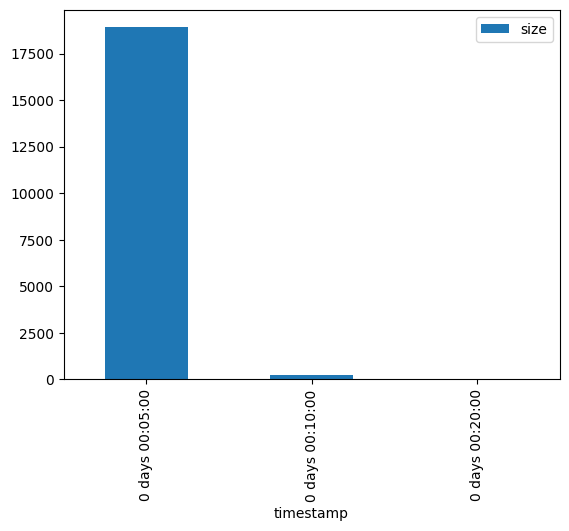

In [35]:
count_diff_intervals_timestamps.set_index("timestamp").plot(kind="bar", y="size")

In [36]:
# Guardo el intervalo en el que llega cada observación
df["arrival_interval"] = df["timestamp"].diff().dt.seconds / 60
# la primera observación la imputo a 5 (para que no esté en na al haber hecho un diff con "nada")
df.at[0,"arrival_interval"] = 5 
df

,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor,arrival_interval
0,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
1,2023-05-05 07:35:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,QUCONTFUAU1AULA1001,5.0
2,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
3,2023-05-05 07:45:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0
4,2023-05-05 07:50:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19141,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
19142,2023-07-11 13:55:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,QUCONTFUAU1AULA1001,5.0
19143,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
19144,2023-07-11 14:05:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,QUCONTFUAU1AULA1001,5.0


## Imputación de valores que llegan irregularmente

In [37]:
dates_imputed = pd.DataFrame(
    {'timestamp_imputed' : pd.date_range(start = df.iloc[0]["timestamp"], 
                                         end = df.iloc[-1]["timestamp"],
                                         freq= "5min")}
)
dates_imputed

,timestamp_imputed
0,2023-05-05 07:30:00
1,2023-05-05 07:35:00
2,2023-05-05 07:40:00
3,2023-05-05 07:45:00
4,2023-05-05 07:50:00
...,...
19372,2023-07-11 13:50:00
19373,2023-07-11 13:55:00
19374,2023-07-11 14:00:00
19375,2023-07-11 14:05:00


In [38]:
df_fill_imputed = dates_imputed.merge(df,
                                      how="left", 
                                      left_on = "timestamp_imputed", 
                                      right_on ="timestamp")
df_fill_imputed

,timestamp_imputed,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,CO2 sensor status,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor,arrival_interval
0,2023-05-05 07:30:00,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
1,2023-05-05 07:35:00,2023-05-05 07:35:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,0.0,240.250,0.0,38183.0,242.0,QUCONTFUAU1AULA1001,5.0
2,2023-05-05 07:40:00,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
3,2023-05-05 07:45:00,2023-05-05 07:45:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0
4,2023-05-05 07:50:00,2023-05-05 07:50:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,0.0,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,2023-07-11 13:50:00,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
19373,2023-07-11 13:55:00,2023-07-11 13:55:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,0.0,0.000,0.0,37925.0,89.0,QUCONTFUAU1AULA1001,5.0
19374,2023-07-11 14:00:00,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0
19375,2023-07-11 14:05:00,2023-07-11 14:05:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,0.0,0.000,0.0,37913.0,88.0,QUCONTFUAU1AULA1001,5.0


In [39]:
df_fill_imputed.columns

Index(['timestamp_imputed', 'timestamp', 'Activity counter', 'Air humidity',
       'Air temperature', 'Ambient light (infrared)',
       'Ambient light (visible + infrared)', 'Barometric pressure',
       'Battery voltage', 'CO2 concentration', 'CO2 sensor status',
       'Illuminance', 'Occupancy', 'Raw IR reading', 'Total VOC', 'id_sensor',
       'arrival_interval'],
      dtype='object')

In [40]:
columns_to_impute = ["Air humidity", "Air temperature", "CO2 concentration", "Occupancy"]
for col in columns_to_impute:
    df_fill_imputed[f"{col}_imputed"] = df_fill_imputed[f"{col}"].interpolate(method="linear")
df_fill_imputed

,timestamp_imputed,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,...,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor,arrival_interval,Air humidity_imputed,Air temperature_imputed,CO2 concentration_imputed,Occupancy_imputed
0,2023-05-05 07:30:00,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,...,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,33.1060,23.1975,426.0,0.0
1,2023-05-05 07:35:00,2023-05-05 07:35:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,...,240.250,0.0,38183.0,242.0,QUCONTFUAU1AULA1001,5.0,33.1060,23.1975,426.0,0.0
2,2023-05-05 07:40:00,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
3,2023-05-05 07:45:00,2023-05-05 07:45:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
4,2023-05-05 07:50:00,2023-05-05 07:50:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,2023-07-11 13:50:00,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,...,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,35.9457,27.4514,408.0,0.0
19373,2023-07-11 13:55:00,2023-07-11 13:55:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,...,0.000,0.0,37925.0,89.0,QUCONTFUAU1AULA1001,5.0,35.9457,27.4514,408.0,0.0
19374,2023-07-11 14:00:00,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,...,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,35.8068,27.4674,411.0,0.0
19375,2023-07-11 14:05:00,2023-07-11 14:05:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,...,0.000,0.0,37913.0,88.0,QUCONTFUAU1AULA1001,5.0,35.8068,27.4674,411.0,0.0


In [41]:
# Falta imputar el id del sensor:
df_fill_imputed["id_sensor"] = np.where(df_fill_imputed["id_sensor"].isna(),"A81758FFFE057FDD",df_fill_imputed["id_sensor"])

In [42]:
# actializo la variable 
df = df_fill_imputed.copy()
df

,timestamp_imputed,timestamp,Activity counter,Air humidity,Air temperature,Ambient light (infrared),Ambient light (visible + infrared),Barometric pressure,Battery voltage,CO2 concentration,...,Illuminance,Occupancy,Raw IR reading,Total VOC,id_sensor,arrival_interval,Air humidity_imputed,Air temperature_imputed,CO2 concentration_imputed,Occupancy_imputed
0,2023-05-05 07:30:00,2023-05-05 07:30:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,...,240.250,0.0,38183.0,242.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,33.1060,23.1975,426.0,0.0
1,2023-05-05 07:35:00,2023-05-05 07:35:00,0.0,33.1060,23.1975,61.0,255.0,94202.0,2.830,426.0,...,240.250,0.0,38183.0,242.0,QUCONTFUAU1AULA1001,5.0,33.1060,23.1975,426.0,0.0
2,2023-05-05 07:40:00,2023-05-05 07:40:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
3,2023-05-05 07:45:00,2023-05-05 07:45:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
4,2023-05-05 07:50:00,2023-05-05 07:50:00,0.0,33.2509,23.2055,63.0,259.0,94204.0,2.831,422.0,...,241.366,0.0,38197.0,246.0,QUCONTFUAU1AULA1001,5.0,33.2509,23.2055,422.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,2023-07-11 13:50:00,2023-07-11 13:50:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,...,0.000,0.0,37925.0,89.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,35.9457,27.4514,408.0,0.0
19373,2023-07-11 13:55:00,2023-07-11 13:55:00,0.0,35.9457,27.4514,0.0,0.0,93844.0,2.734,408.0,...,0.000,0.0,37925.0,89.0,QUCONTFUAU1AULA1001,5.0,35.9457,27.4514,408.0,0.0
19374,2023-07-11 14:00:00,2023-07-11 14:00:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,...,0.000,0.0,37913.0,88.0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,5.0,35.8068,27.4674,411.0,0.0
19375,2023-07-11 14:05:00,2023-07-11 14:05:00,0.0,35.8068,27.4674,0.0,0.0,93844.0,2.734,411.0,...,0.000,0.0,37913.0,88.0,QUCONTFUAU1AULA1001,5.0,35.8068,27.4674,411.0,0.0


## Últimas limpiezas y categorizaciones finales 

A continuación, voy a asumir como variables de interés las imputadas y quedarme únicamente con la información que interesa

In [43]:
# A continuación, voy a asumir como variables de interés las imputadas 
df = df\
    .rename(columns = {"Air temperature_imputed": "Temperatura",
                       "Air humidity_imputed": "Humedad",
                       "CO2 concentration_imputed": "CO2",
                       "timestamp_imputed":"Timestamp",
                       "Occupancy_imputed":"Ocupacion"
                      })[["id_sensor","Timestamp","Temperatura","Humedad","CO2","Ocupacion"]]
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0
...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0


In [44]:
# Tenemos observaciones que llegan en diferentes intervalos de tiempo, vamos a ver cuál es la distribución en la que llegan
# esos intervalos para en función de eso tomar una decisión sobre si imputar valores dado un intervalo de tiempo a pesar 
# de que no se tengan esos valores:
count_diff_intervals_timestamps = df["Timestamp"].diff()\
.to_frame()\
.groupby("Timestamp")\
.size()\
.reset_index()\
.rename(columns={0:"size"})
count_diff_intervals_timestamps

,Timestamp,size
0,0 days 00:05:00,19376


In [45]:
#Tasa metabólica, para nuestras condiciones es 1.2
M = 1.2
#Velocidad del aire, estamos suponiendo que es 0.01
v = 0.01

df["Icl"] = np.where(
    (df['Timestamp'] > pd.Timestamp(2023,3,21)) & (df['Timestamp'] < pd.Timestamp(2023,9,21)),
    0.5,
    1
)
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5
...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5


In [46]:
df["IDA"] = np.where(
    df['CO2'] <= 750, 'IDA 1',
    np.where((df['CO2'] > 750) & (df['CO2']<=900), 'IDA 2',
            np.where((df['CO2'] > 900) & (df['CO2']<=1200), 'IDA 3',
                     'IDA 4'
            )
    )
)

df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1
...,...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1


In [47]:
#Cálculo de la velocidad relativa del aire
v_r = v_relative(v=v, met= M)
v_r

array(0.07)

In [48]:
# Calcular el ITRC
df['Temperatura Radiante ITRC'] = 0.5 * df['Temperatura'] + 0.5 * df['Temperatura'] * df['Humedad'] / 100 + 1.2 * (df['Temperatura'] - df['Temperatura'] * df['Humedad'] / 100) - 10.7
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA,Temperatura Radiante ITRC
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124
...,...,...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942


In [49]:
# Esta celda tarda mucho. Lo mejor que se puede hacer cuando el tiempo de ejecución es largo es una 
# LIST COMPREHENSION
def own_pmv_ppd(temperatura, temperatura_radiante, humedad, icl):
    return pmv_ppd(tdb=temperatura, 
                   tr=temperatura_radiante, 
                   vr=v_r, 
                   rh=humedad, 
                   met=M, 
                   clo= clo_dynamic(clo=icl, met=M)
                  )

df2 = pd.DataFrame([own_pmv_ppd(temperatura, temperatura_globo, humedad, icl) 
                    for temperatura,temperatura_globo,humedad,icl 
                    in df[["Temperatura","Temperatura Radiante ITRC","Humedad","Icl"]].values])
df2

,pmv,ppd
0,-0.52,10.7
1,-0.52,10.7
2,-0.52,10.7
3,-0.52,10.7
4,-0.52,10.7
...,...,...
19372,1.00,26.3
19373,1.00,26.3
19374,1.01,26.7
19375,1.01,26.7


In [50]:
df = pd.concat([df,df2], axis=1)
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA,Temperatura Radiante ITRC,pmv,ppd
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7
...,...,...,...,...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7


In [51]:
bins = [-np.inf, 6, 10, 15, np.inf]   # Define los puntos de corte para cada categoría
labels = ['A', 'B', 'C', 'D']         # Define las etiquetas para cada categoría
df['Categoria'] = pd.cut(df['ppd'], bins=bins, labels=labels, include_lowest=True)
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA,Temperatura Radiante ITRC,pmv,ppd,Categoria
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7,C
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7,C
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C
...,...,...,...,...,...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3,D
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3,D
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7,D
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7,D


In [52]:
estrellas_dict = {
    ('IDA 1', 'A'): 5,
    ('IDA 2', 'A'): 5,
    ('IDA 1', 'B'): 4,
    ('IDA 2', 'B'): 4,
    ('IDA 1', 'C'): 3,
    ('IDA 2', 'C'): 3,
    ('IDA 3', 'A'): 2,
    ('IDA 3', 'B'): 2,
    ('IDA 3', 'C'): 1,
    ('IDA 4', 'A'): 0,
    ('IDA 4', 'B'): 0,
    ('IDA 4', 'C'): 0,
    ('IDA 1', 'D'): 0,
    ('IDA 2', 'D'): 0,
    ('IDA 3', 'D'): 0,
    ('IDA 4', 'D'): 0
}
df['Estrellas'] = df[['IDA', 'Categoria']].apply(lambda x: estrellas_dict.get(tuple(x)), axis=1)
df

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA,Temperatura Radiante ITRC,pmv,ppd,Categoria,Estrellas
0,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:30:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7,C,3
1,QUCONTFUAU1AULA1001,2023-05-05 07:35:00,23.1975,33.1060,426.0,0.0,0.5,IDA 1,23.359915,-0.52,10.7,C,3
2,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-05-05 07:40:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C,3
3,QUCONTFUAU1AULA1001,2023-05-05 07:45:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C,3
4,QUCONTFUAU1AULA1001,2023-05-05 07:50:00,23.2055,33.2509,422.0,0.0,0.5,IDA 1,23.348124,-0.52,10.7,C,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19372,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 13:50:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3,D,0
19373,QUCONTFUAU1AULA1001,2023-07-11 13:55:00,27.4514,35.9457,408.0,0.0,0.5,IDA 1,29.060061,1.00,26.3,D,0
19374,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-07-11 14:00:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7,D,0
19375,QUCONTFUAU1AULA1001,2023-07-11 14:05:00,27.4674,35.8068,411.0,0.0,0.5,IDA 1,29.109942,1.01,26.7,D,0


In [53]:
df.sort_values('Estrellas', ascending=False).tail(50)

,id_sensor,Timestamp,Temperatura,Humedad,CO2,Ocupacion,Icl,IDA,Temperatura Radiante ITRC,pmv,ppd,Categoria,Estrellas
8241,QUCONTFUAU1AULA1001,2023-06-02 22:15:00,20.8263,54.9386,395.0,0.0,0.5,IDA 1,16.695536,-1.68,60.5,D,0
8242,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-06-02 22:20:00,20.8183,54.9813,398.0,0.0,0.5,IDA 1,16.678790,-1.68,60.7,D,0
8243,QUCONTFUAU1AULA1001,2023-06-02 22:25:00,20.8183,54.9813,398.0,0.0,0.5,IDA 1,16.678790,-1.68,60.7,D,0
8244,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-06-02 22:30:00,20.8156,55.0393,405.0,0.0,0.5,IDA 1,16.666788,-1.68,60.7,D,0
8245,QUCONTFUAU1AULA1001,2023-06-02 22:35:00,20.8156,55.0393,405.0,0.0,0.5,IDA 1,16.666788,-1.68,60.7,D,0
8246,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-06-02 22:40:00,20.8076,55.0622,401.0,0.0,0.5,IDA 1,16.652934,-1.68,60.9,D,0
8247,QUCONTFUAU1AULA1001,2023-06-02 22:45:00,20.8076,55.0622,401.0,0.0,0.5,IDA 1,16.652934,-1.68,60.9,D,0
8248,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-06-02 22:50:00,20.8022,55.0698,401.0,0.0,0.5,IDA 1,16.644729,-1.69,61.0,D,0
8249,QUCONTFUAU1AULA1001,2023-06-02 22:55:00,20.8022,55.0698,401.0,0.0,0.5,IDA 1,16.644729,-1.69,61.0,D,0
8250,70B3D57BA0001C2D&QUCONTFUAU1AULA1001,2023-06-02 23:00:00,20.8022,55.1049,402.0,0.0,0.5,IDA 1,16.639618,-1.69,61.0,D,0


In [54]:
df.groupby('IDA').size().reset_index(name='Cantidad')

,IDA,Cantidad
0,IDA 1,18441
1,IDA 2,214
2,IDA 3,361
3,IDA 4,361


In [55]:
df[df['Ocupacion'] > 0].groupby('IDA').size().reset_index(name='Cantidad')

,IDA,Cantidad
0,IDA 1,576
1,IDA 2,84
2,IDA 3,215
3,IDA 4,229


In [56]:
df.groupby('Categoria').size().reset_index(name='Cantidad')

,Categoria,Cantidad
0,A,2371
1,B,3021
2,C,3714
3,D,10271


In [57]:
df[df['Ocupacion'] > 0].groupby('Categoria').size().reset_index(name='Cantidad')

,Categoria,Cantidad
0,A,208
1,B,225
2,C,185
3,D,486


In [58]:
df.groupby('Estrellas').size().reset_index(name='Cantidad')

,Estrellas,Cantidad
0,0,10432
1,1,22
2,2,139
3,3,3650
4,4,2925
5,5,2209


In [59]:
df[df['Ocupacion'] > 0].groupby('Estrellas').size().reset_index(name='Cantidad')

,Estrellas,Cantidad
0,0,600
1,1,22
2,2,105
3,3,132
4,4,141
5,5,104


# Exportación de Datos a la BBDD TFG

In [60]:
from sqlalchemy import create_engine
import pymysql

In [61]:
# Leer las credenciales
with open('creds/TFG_credentials.json', 'r') as f:
    creds = json.load(f)

# Conexión con la BBDD 
engine = create_engine(f'mysql+pymysql://{creds["user"]}:{creds["password"]}@{creds["server"]}:{creds["port"]}/{creds["database"]}')

In [62]:
#Subida de los resultados a BBDD
df.to_sql('Data_sensores', engine, if_exists='replace', index= True)

print('Dataframe exportado exitosamente a MySQL')

Dataframe exportado exitosamente a MySQL


In [63]:
#Desconexión con la BBDD
engine.dispose()
print('Conexión a la BBDD cerrada exitosamente')

Conexión a la BBDD cerrada exitosamente


## Exportacion de df para creación de graficos de resultados

In [64]:
df.to_pickle('Datos_sensores.pkl')